# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

import cv2
import random
import tensorflow as tf
import seaborn as sns
import os
import random
import keras

from keras import models
from keras import layers
from keras import optimizers
from keras.models import Model, Sequential
from keras.layers import Conv2D, Conv2DTranspose, Reshape
from keras.applications.inception_resnet_v2 import InceptionResNetV2, decode_predictions, preprocess_input
from keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose
from keras.layers import Activation, Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray, xyz2lab
from skimage.io import imsave
from keras.layers import MaxPooling2D, Flatten, Dense, Dropout, Activation, InputLayer, BatchNormalization  
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
                    
import pydot as pyd
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from matplotlib.image import imread
from sklearn.cluster import KMeans

keras.utils.vis_utils.pydot = pyd

Using TensorFlow backend.


# Import Datasets

In [2]:
L_images = np.load('l/gray_scale.npy')

In [3]:
AB_images_1 = np.load('ab/ab/ab1.npy')
AB_images_2 = np.load('ab/ab/ab2.npy')
AB_images_3 = np.load('ab/ab/ab3.npy')

# Exploratory Data Analysis

In [4]:
L_images.shape

(25000, 224, 224)

In [5]:
AB_images_1.shape

(10000, 224, 224, 2)

In [6]:
AB_images = np.concatenate((AB_images_1, AB_images_2, AB_images_3))

In [7]:
AB_images.shape

(25000, 224, 224, 2)

# Normalizing Data

In [8]:
# def normalize_L(data):
#     L = []
#     i = 0
#     while i <= 30:
#         for img in np.nditer(data[i]):
#             img /= 100
#         L.append(img)
#         i += 1
#     L = np.array(L, dtype='float')
#     return L

# def normalize_ab(data):
#     for img in np.nditer(data):
#         img = img*(1.0/128)
#     return data

In [9]:
# L_norm = normalize_L(L_images)

In [10]:
# AB_norm_1 = normalize_ab(AB_images_1)

# Preprocessing L_images to make RGB

In [11]:
def prep_L(L_images, batch_size = 300):
    # Create and empty array of given batch size, 224x224, with three channels
    # so that the L channel can fall in a tensor that will eventually hold all three
    # RGB channels
    L_imgs = np.zeros((batch_size, 224, 224, 3))
    # fFr every channel in range 2
    for i in range(0, 3):
        # a new image in the RGB_imgs array will be a greyscale image from L_images
        L_imgs[:batch_size, :, :,i] = L_images[:batch_size]
    # Return the standardized version of this new array.
    return preprocess_input(L_imgs)

# Creating RGB targets from L and AB values

In [12]:
def make_RGB(L_images, AB_images, batch_size = 300):
    # Create and empty array of the appropriate size to hold
    # L and AB images. It will be of batch size, 224x244
    # and be composed of three color channels for RGB
    RGB_imgs = np.zeros((batch_size, 224, 224, 3))
    # The first color channel will be the L in L_images, up to the batch size
    RGB_imgs[:, :, :, 0] = L_images[0:batch_size]
    # The second /third color channels will be the AB from AB_images
    RGB_imgs[:, :, :, 1:] = AB_images[0:batch_size]
    # Convert everything to the same file type
    RGB_imgs = RGB_imgs.astype("uint8")
    # Create a new empty list to hold all of the RGB images
    RGB_array = []
    # for every image in the range of the batch size, convert LAB to RGB
    # and then append to our empty list of imgs_
    for i in range(0, batch_size):
        RGB_array.append(cv2.cvtColor(RGB_imgs[i], cv2.COLOR_LAB2RGB))
    # Turn our new list of RGB images back into an array   
    RGB_array = np.array(RGB_array)
    return RGB_array

# Creating Train and Target Data

In [13]:
imgs_input = prep_L(L_images, batch_size = 300)

In [14]:
imgs_output = preprocess_input(make_RGB(L_images, AB_images, batch_size = 300))

In [15]:
imgs_input.dtype

dtype('float64')

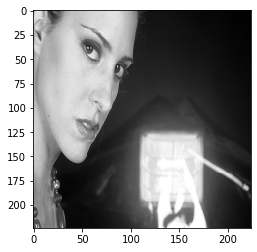

In [16]:
plt.imshow(L_images[25], cmap='gray')

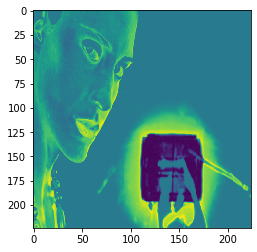

In [17]:
img = imgs_output[25]
lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
L, A, B = cv2.split(lab)
plt.imshow(A)

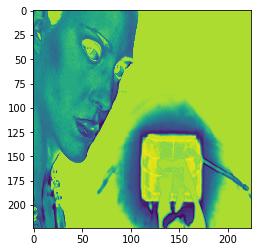

In [18]:
plt.imshow(B)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


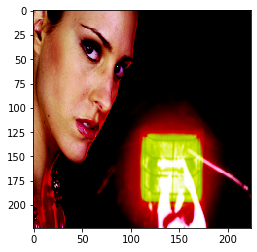

In [19]:
plt.imshow(imgs_output[25]);

# Building a Baseline Convolutional Neural Network

In [20]:
model_simple = Sequential()
model_simple.add(Conv2D(strides = 1, kernel_size = 3, filters = 12, padding = "same", activation = 'relu'))
model_simple.add(Conv2D(strides = 1, kernel_size = 3, filters = 12, padding = "same", activation = 'relu'))
model_simple.add(Conv2DTranspose(strides = 1, kernel_size = 3, filters = 12, padding = "same", activation = 'relu'))
model_simple.add(Conv2DTranspose(strides = 1, kernel_size = 3, filters = 3, padding = "same", activation = 'relu'))

In [21]:
model_simple.compile(optimizer='adam', loss='mse', metrics=['acc'])

In [23]:
model_simple.fit(imgs_input, imgs_output, epochs = 15)

Epoch 1/15
300/300 [==============================] - 8s 28ms/step - loss: 0.4089 - acc: 0.3090
Epoch 2/15
300/300 [==============================] - 8s 27ms/step - loss: 0.3404 - acc: 0.3853
Epoch 3/15
300/300 [==============================] - 8s 27ms/step - loss: 0.3351 - acc: 0.4651
Epoch 4/15
300/300 [==============================] - 8s 27ms/step - loss: 0.3332 - acc: 0.5221
Epoch 5/15
300/300 [==============================] - 8s 27ms/step - loss: 0.3321 - acc: 0.5595
Epoch 6/15
300/300 [==============================] - 8s 28ms/step - loss: 0.3316 - acc: 0.5288
Epoch 7/15
300/300 [==============================] - 8s 28ms/step - loss: 0.3313 - acc: 0.5617
Epoch 8/15
300/300 [==============================] - 8s 28ms/step - loss: 0.3309 - acc: 0.5659
Epoch 9/15
300/300 [==============================] - 8s 27ms/step - loss: 0.3307 - acc: 0.5564
Epoch 10/15
300/300 [==============================] - 8s 28ms/step - loss: 0.3304 - acc: 0.5685
Epoch 11/15
300/300 [==================

In [24]:
print(model_simple.evaluate(imgs_input, imgs_output))

300/300 [==============================] - 3s 11ms/step
[0.32921485145886736, 0.5762767195701599]


# Predicting Baseline Output

In [25]:
output = model_simple.predict(imgs_input)

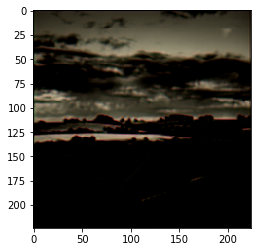

In [26]:
plt.imshow(output[30])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


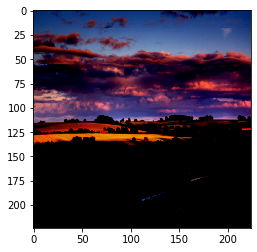

In [28]:
plt.imshow(imgs_output[30])

# Evaluating Baseline Performance

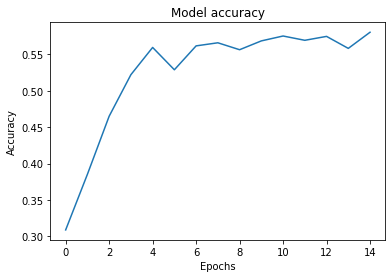

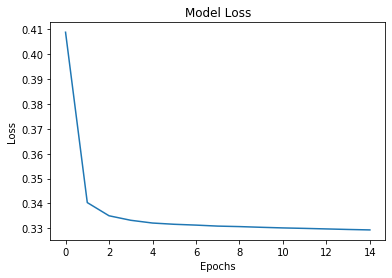

In [30]:
h = model_simple.history

plt.plot(h.history['acc'])
plt.xlabel('Epochs')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.show()

plt.plot(h.history['loss'])
plt.xlabel('Epochs')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.show()

 # Creating a more powerful CNN

In [31]:
# Building the neural network
model = Sequential()
model.add(InputLayer(input_shape=(224,224,3)))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', strides=2))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(3, (3, 3), activation='tanh', padding='same'))

In [32]:
# Finish model
model.compile(optimizer='rmsprop',loss='mse', metrics=['acc'])

In [33]:
model.fit(imgs_input, imgs_output, epochs = 15)

Epoch 1/15
300/300 [==============================] - 9s 29ms/step - loss: 0.2139 - acc: 0.3103
Epoch 2/15
300/300 [==============================] - 9s 29ms/step - loss: 0.1129 - acc: 0.4715
Epoch 3/15
300/300 [==============================] - 9s 29ms/step - loss: 0.1016 - acc: 0.5285
Epoch 4/15
300/300 [==============================] - 9s 28ms/step - loss: 0.0916 - acc: 0.5576
Epoch 5/15
300/300 [==============================] - 9s 29ms/step - loss: 0.0951 - acc: 0.5636
Epoch 6/15
300/300 [==============================] - 8s 28ms/step - loss: 0.0926 - acc: 0.5671
Epoch 7/15
300/300 [==============================] - 8s 28ms/step - loss: 0.0864 - acc: 0.5434
Epoch 8/15
300/300 [==============================] - 8s 28ms/step - loss: 0.0862 - acc: 0.5495
Epoch 9/15
300/300 [==============================] - 9s 29ms/step - loss: 0.0861 - acc: 0.5738
Epoch 10/15
300/300 [==============================] - 8s 28ms/step - loss: 0.0793 - acc: 0.5539
Epoch 11/15
300/300 [==================

# Predicting updated CNN Outputs

In [34]:
output = model.predict(imgs_input)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


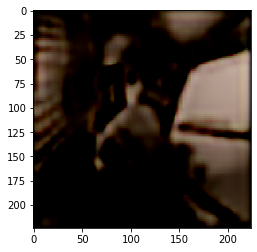

In [35]:
plt.imshow(output[4])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


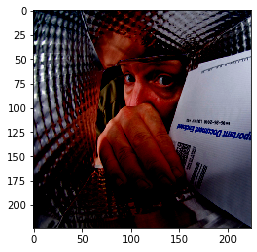

In [37]:
plt.imshow(imgs_output[4])

# Building a Fully Connected Network with no Upsampling or Pooling

In [56]:
# Building the neural network
updated_model = Sequential()
updated_model.add(InputLayer(input_shape=(224,224,3)))
updated_model.add(Conv2D(8, (3, 3), activation='relu', padding='same', strides=1))
updated_model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
updated_model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
updated_model.add(Conv2D(16, (3, 3), activation='relu', padding='same', strides=1))
updated_model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
updated_model.add(Conv2D(32, (3, 3), activation='relu', padding='same', strides=1))
updated_model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
updated_model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
updated_model.add(Conv2D(3, (3, 3), activation='tanh', padding='same'))

In [57]:
imgs_input.shape

(300, 224, 224, 3)

In [61]:
# Finish model
updated_model.compile(optimizer='adam',loss='mse', metrics=['acc'])

In [62]:
new_stopping_cb = keras.callbacks.EarlyStopping(patience=10, monitor='acc',
                                                restore_best_weights=True)

In [63]:
updated_model.fit(imgs_input, imgs_output, epochs = 100, callbacks=[new_stopping_cb] )

Epoch 1/100
300/300 [==============================] - 37s 123ms/step - loss: 0.1978 - acc: 0.4772
Epoch 2/100
300/300 [==============================] - 36s 122ms/step - loss: 0.0853 - acc: 0.5562
Epoch 3/100
300/300 [==============================] - 37s 122ms/step - loss: 0.0714 - acc: 0.3756
Epoch 4/100
300/300 [==============================] - 36s 121ms/step - loss: 0.0672 - acc: 0.5859
Epoch 5/100
300/300 [==============================] - 43s 145ms/step - loss: 0.0642 - acc: 0.5203
Epoch 6/100
300/300 [==============================] - 46s 154ms/step - loss: 0.0614 - acc: 0.5786
Epoch 7/100
300/300 [==============================] - 46s 153ms/step - loss: 0.0590 - acc: 0.5682
Epoch 8/100
300/300 [==============================] - 47s 155ms/step - loss: 0.0562 - acc: 0.5802
Epoch 9/100
300/300 [==============================] - 47s 157ms/step - loss: 0.0544 - acc: 0.5669
Epoch 10/100
300/300 [==============================] - 46s 155ms/step - loss: 0.0534 - acc: 0.5109
Epoch 11/

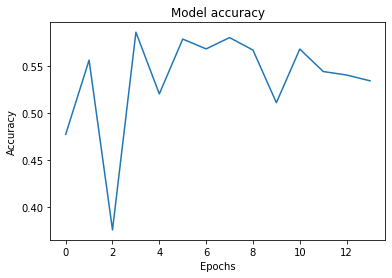

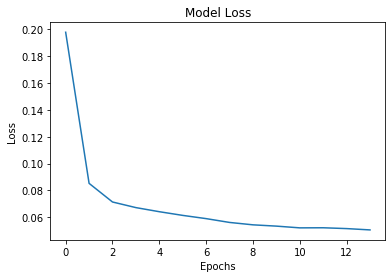

In [64]:
h = updated_model.history

plt.plot(h.history['acc'])
plt.xlabel('Epochs')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.show()

plt.plot(h.history['loss'])
plt.xlabel('Epochs')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.show()

In [65]:
output = updated_model.predict(imgs_input)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


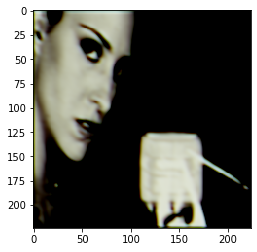

In [67]:
plt.imshow(output[25])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


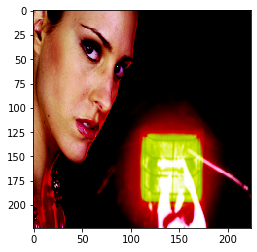

In [47]:
plt.imshow(imgs_output[25])

# Re-running updated CNN with Accuracy Stopping

In [68]:
acc_stopping_cb = keras.callbacks.EarlyStopping(patience=75, monitor='acc',
                                                restore_best_weights=True)

In [69]:
model.fit(imgs_input, imgs_output, epochs = 1000, callbacks=[acc_stopping_cb])

Epoch 1/1000
300/300 [==============================] - 11s 36ms/step - loss: 0.0770 - acc: 0.5648
Epoch 2/1000
300/300 [==============================] - 11s 36ms/step - loss: 0.0718 - acc: 0.5550
Epoch 3/1000
300/300 [==============================] - 11s 36ms/step - loss: 0.0761 - acc: 0.5770
Epoch 4/1000
300/300 [==============================] - 11s 35ms/step - loss: 0.0768 - acc: 0.5547
Epoch 5/1000
300/300 [==============================] - 11s 35ms/step - loss: 0.0742 - acc: 0.5644
Epoch 6/1000
300/300 [==============================] - 11s 36ms/step - loss: 0.0730 - acc: 0.5731
Epoch 7/1000
300/300 [==============================] - 11s 36ms/step - loss: 0.0719 - acc: 0.5748
Epoch 8/1000
300/300 [==============================] - 11s 36ms/step - loss: 0.0735 - acc: 0.5466
Epoch 9/1000
300/300 [==============================] - 11s 36ms/step - loss: 0.0726 - acc: 0.5690
Epoch 10/1000
300/300 [==============================] - 11s 38ms/step - loss: 0.0723 - acc: 0.5517
Epoch 11/

300/300 [==============================] - 11s 36ms/step - loss: 0.0630 - acc: 0.5681
Epoch 84/1000
300/300 [==============================] - 11s 36ms/step - loss: 0.0608 - acc: 0.5775
Epoch 85/1000
300/300 [==============================] - 11s 36ms/step - loss: 0.0617 - acc: 0.5844
Epoch 86/1000
300/300 [==============================] - 11s 37ms/step - loss: 0.0616 - acc: 0.5707
Epoch 87/1000
300/300 [==============================] - 11s 36ms/step - loss: 0.0610 - acc: 0.5761
Epoch 88/1000
300/300 [==============================] - 11s 36ms/step - loss: 0.0614 - acc: 0.5808
Epoch 89/1000
300/300 [==============================] - 11s 36ms/step - loss: 0.0614 - acc: 0.5720
Epoch 90/1000
300/300 [==============================] - 11s 36ms/step - loss: 0.0616 - acc: 0.5721
Epoch 91/1000
300/300 [==============================] - 11s 36ms/step - loss: 0.0596 - acc: 0.5787
Epoch 92/1000
300/300 [==============================] - 11s 36ms/step - loss: 0.0608 - acc: 0.5802
Epoch 93/1000


300/300 [==============================] - 11s 36ms/step - loss: 0.0545 - acc: 0.5662
Epoch 246/1000
300/300 [==============================] - 11s 36ms/step - loss: 0.0544 - acc: 0.5741
Epoch 247/1000
300/300 [==============================] - 11s 36ms/step - loss: 0.0564 - acc: 0.5644
Epoch 248/1000
300/300 [==============================] - 11s 36ms/step - loss: 0.0547 - acc: 0.5843
Epoch 249/1000
300/300 [==============================] - 11s 36ms/step - loss: 0.0560 - acc: 0.5232
Epoch 250/1000
300/300 [==============================] - 11s 36ms/step - loss: 0.0541 - acc: 0.5567
Epoch 251/1000
300/300 [==============================] - 11s 36ms/step - loss: 0.0562 - acc: 0.5768
Epoch 252/1000
300/300 [==============================] - 11s 36ms/step - loss: 0.0552 - acc: 0.5646
Epoch 253/1000
300/300 [==============================] - 11s 35ms/step - loss: 0.0529 - acc: 0.5803
Epoch 254/1000
300/300 [==============================] - 11s 35ms/step - loss: 0.0571 - acc: 0.5732
Epoch

300/300 [==============================] - 8s 28ms/step - loss: 0.0525 - acc: 0.5774
Epoch 408/1000
300/300 [==============================] - 8s 28ms/step - loss: 0.0516 - acc: 0.5893
Epoch 409/1000
300/300 [==============================] - 8s 28ms/step - loss: 0.0523 - acc: 0.5898
Epoch 410/1000
300/300 [==============================] - 9s 28ms/step - loss: 0.0525 - acc: 0.5657
Epoch 411/1000
300/300 [==============================] - 8s 28ms/step - loss: 0.0502 - acc: 0.5740
Epoch 412/1000
300/300 [==============================] - 8s 28ms/step - loss: 0.0525 - acc: 0.5731
Epoch 413/1000
300/300 [==============================] - 8s 28ms/step - loss: 0.0523 - acc: 0.5859
Epoch 414/1000
300/300 [==============================] - 9s 29ms/step - loss: 0.0518 - acc: 0.5863
Epoch 415/1000
300/300 [==============================] - 8s 28ms/step - loss: 0.0516 - acc: 0.5517
Epoch 416/1000
300/300 [==============================] - 8s 28ms/step - loss: 0.0530 - acc: 0.5953
Epoch 417/1000


300/300 [==============================] - 8s 28ms/step - loss: 0.0506 - acc: 0.5816
Epoch 490/1000
300/300 [==============================] - 9s 29ms/step - loss: 0.0509 - acc: 0.5756
Epoch 491/1000
300/300 [==============================] - 9s 29ms/step - loss: 0.0508 - acc: 0.5735
Epoch 492/1000
300/300 [==============================] - 9s 29ms/step - loss: 0.0497 - acc: 0.5911
Epoch 493/1000
300/300 [==============================] - 9s 28ms/step - loss: 0.0525 - acc: 0.5791
Epoch 494/1000
300/300 [==============================] - 8s 28ms/step - loss: 0.0500 - acc: 0.5846
Epoch 495/1000
300/300 [==============================] - 9s 28ms/step - loss: 0.0512 - acc: 0.5807
Epoch 496/1000
300/300 [==============================] - 8s 28ms/step - loss: 0.0498 - acc: 0.5638
Epoch 497/1000
300/300 [==============================] - 9s 29ms/step - loss: 0.0500 - acc: 0.5822
Epoch 498/1000
300/300 [==============================] - 8s 28ms/step - loss: 0.0508 - acc: 0.5715
Epoch 499/1000


300/300 [==============================] - 8s 28ms/step - loss: 0.0499 - acc: 0.5759
Epoch 572/1000
300/300 [==============================] - 8s 28ms/step - loss: 0.0485 - acc: 0.5786
Epoch 573/1000
300/300 [==============================] - 8s 28ms/step - loss: 0.0501 - acc: 0.5763
Epoch 574/1000
300/300 [==============================] - 8s 28ms/step - loss: 0.0490 - acc: 0.5660
Epoch 575/1000
300/300 [==============================] - 8s 28ms/step - loss: 0.0495 - acc: 0.5878
Epoch 576/1000
300/300 [==============================] - 8s 28ms/step - loss: 0.0483 - acc: 0.5875
Epoch 577/1000
300/300 [==============================] - 8s 28ms/step - loss: 0.0494 - acc: 0.5677
Epoch 578/1000
300/300 [==============================] - 8s 28ms/step - loss: 0.0510 - acc: 0.5871
Epoch 579/1000
300/300 [==============================] - 8s 28ms/step - loss: 0.0482 - acc: 0.5894
Epoch 580/1000
300/300 [==============================] - 9s 28ms/step - loss: 0.0505 - acc: 0.5813
Epoch 581/1000


300/300 [==============================] - 9s 28ms/step - loss: 0.0496 - acc: 0.5590
Epoch 654/1000
300/300 [==============================] - 9s 29ms/step - loss: 0.0487 - acc: 0.5923
Epoch 655/1000
300/300 [==============================] - 9s 29ms/step - loss: 0.0478 - acc: 0.5756
Epoch 656/1000
300/300 [==============================] - 9s 29ms/step - loss: 0.0482 - acc: 0.5936
Epoch 657/1000
300/300 [==============================] - 8s 28ms/step - loss: 0.0489 - acc: 0.5784
Epoch 658/1000
300/300 [==============================] - 9s 29ms/step - loss: 0.0488 - acc: 0.5794
Epoch 659/1000
300/300 [==============================] - 9s 29ms/step - loss: 0.0487 - acc: 0.5724
Epoch 660/1000
300/300 [==============================] - 8s 28ms/step - loss: 0.0491 - acc: 0.5710
Epoch 661/1000
300/300 [==============================] - 8s 28ms/step - loss: 0.0481 - acc: 0.6014
Epoch 662/1000
300/300 [==============================] - 8s 28ms/step - loss: 0.0495 - acc: 0.5931
Epoch 663/1000


300/300 [==============================] - 8s 28ms/step - loss: 0.0469 - acc: 0.5859
Epoch 736/1000
300/300 [==============================] - 9s 29ms/step - loss: 0.0477 - acc: 0.5882
Epoch 737/1000
300/300 [==============================] - 8s 28ms/step - loss: 0.0484 - acc: 0.5796
Epoch 738/1000
300/300 [==============================] - 8s 28ms/step - loss: 0.0462 - acc: 0.5879
Epoch 739/1000
300/300 [==============================] - 8s 28ms/step - loss: 0.0472 - acc: 0.6075
Epoch 740/1000
300/300 [==============================] - 9s 28ms/step - loss: 0.0481 - acc: 0.5724
Epoch 741/1000
300/300 [==============================] - 9s 28ms/step - loss: 0.0473 - acc: 0.5820
Epoch 742/1000
300/300 [==============================] - 8s 28ms/step - loss: 0.0473 - acc: 0.5823
Epoch 743/1000
300/300 [==============================] - 8s 28ms/step - loss: 0.0465 - acc: 0.5803
Epoch 744/1000
300/300 [==============================] - 8s 28ms/step - loss: 0.0484 - acc: 0.5782
Epoch 745/1000


300/300 [==============================] - 8s 28ms/step - loss: 0.0485 - acc: 0.5890
Epoch 818/1000
300/300 [==============================] - 8s 28ms/step - loss: 0.0457 - acc: 0.5867
Epoch 819/1000
300/300 [==============================] - 8s 28ms/step - loss: 0.0461 - acc: 0.5814
Epoch 820/1000
300/300 [==============================] - 9s 28ms/step - loss: 0.0463 - acc: 0.5895
Epoch 821/1000
300/300 [==============================] - 9s 28ms/step - loss: 0.0453 - acc: 0.5820
Epoch 822/1000
300/300 [==============================] - 8s 28ms/step - loss: 0.0489 - acc: 0.5849
Epoch 823/1000
300/300 [==============================] - 8s 28ms/step - loss: 0.0455 - acc: 0.5911
Epoch 824/1000
300/300 [==============================] - 8s 28ms/step - loss: 0.0466 - acc: 0.5880
Epoch 825/1000
300/300 [==============================] - 8s 28ms/step - loss: 0.0460 - acc: 0.5778
Epoch 826/1000
300/300 [==============================] - 8s 28ms/step - loss: 0.0476 - acc: 0.5699
Epoch 827/1000


300/300 [==============================] - 8s 28ms/step - loss: 0.0461 - acc: 0.5970
Epoch 900/1000
300/300 [==============================] - 8s 28ms/step - loss: 0.0459 - acc: 0.5745
Epoch 901/1000
300/300 [==============================] - 9s 28ms/step - loss: 0.0466 - acc: 0.5956
Epoch 902/1000
300/300 [==============================] - 8s 28ms/step - loss: 0.0450 - acc: 0.5723
Epoch 903/1000
300/300 [==============================] - 9s 29ms/step - loss: 0.0456 - acc: 0.5797
Epoch 904/1000
300/300 [==============================] - 9s 29ms/step - loss: 0.0457 - acc: 0.5678
Epoch 905/1000
300/300 [==============================] - 9s 28ms/step - loss: 0.0467 - acc: 0.5878
Epoch 906/1000
300/300 [==============================] - 9s 28ms/step - loss: 0.0450 - acc: 0.5997
Epoch 907/1000
300/300 [==============================] - 9s 28ms/step - loss: 0.0454 - acc: 0.5647
Epoch 908/1000
300/300 [==============================] - 9s 28ms/step - loss: 0.0464 - acc: 0.5490
Epoch 909/1000


300/300 [==============================] - 9s 29ms/step - loss: 0.0456 - acc: 0.5961
Epoch 982/1000
300/300 [==============================] - 9s 28ms/step - loss: 0.0452 - acc: 0.5829
Epoch 983/1000
300/300 [==============================] - 8s 28ms/step - loss: 0.0439 - acc: 0.5765
Epoch 984/1000
300/300 [==============================] - 9s 29ms/step - loss: 0.0454 - acc: 0.5823
Epoch 985/1000
300/300 [==============================] - 9s 28ms/step - loss: 0.0438 - acc: 0.5933
Epoch 986/1000
300/300 [==============================] - 9s 28ms/step - loss: 0.0454 - acc: 0.5784
Epoch 987/1000
300/300 [==============================] - 9s 29ms/step - loss: 0.0450 - acc: 0.5724
Epoch 988/1000
300/300 [==============================] - 8s 28ms/step - loss: 0.0454 - acc: 0.5891
Epoch 989/1000
300/300 [==============================] - 8s 28ms/step - loss: 0.0456 - acc: 0.5642
Epoch 990/1000
300/300 [==============================] - 8s 28ms/step - loss: 0.0463 - acc: 0.5809
Epoch 991/1000


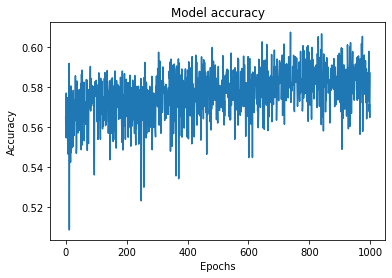

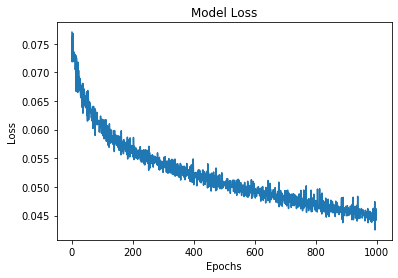

In [70]:
h = model.history

plt.plot(h.history['acc'])
plt.xlabel('Epochs')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.show()

plt.plot(h.history['loss'])
plt.xlabel('Epochs')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.show()

# Predicting Accuracy CNN Outputs

In [71]:
output = model.predict(imgs_input)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


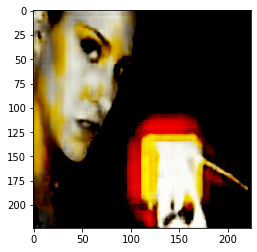

In [72]:
plt.imshow(output[25])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


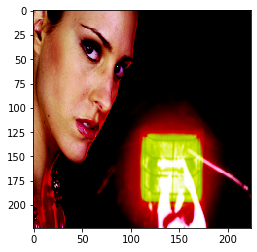

In [74]:
plt.imshow(imgs_output[25])

# Data Augmentation and Feature Mapping

In [ ]:
imgs_for_input.shape

In [ ]:
imgs_for_input[0].shape

In [ ]:
# The following code loads two sample images, then it creates two filters
# and applies them to both images; then it displays one of the resulting
# feature maps

# from sklearn.datasets import load_sample_image
# Load sample images
# china = load_sample_image('china.jpg')/255
# flower = load_sample_image('flower.jpg')/255

image = imgs_for_input
batch_size, height, width, channels = imgs_for_input.shape

# Create two filters
filters = np.zeros(shape=(7,7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1 # Vertical Line
filters[3, :, :, 1] = 1 # Horizontal Line

outputs = tf.nn.conv2d(image, filters, strides=1, padding='SAME')

plt.figure(figsize=(18,10))
plt.imshow(outputs[0, :, :, 1], cmap='gray') # Plot the first image's 2nd feature map
plt.show()

plt.figure(figsize=(18,10))
plt.imshow(outputs[0,:,:,0], cmap='gray')

# Pixel intensity is represented as a byte from 0 to 255, so we scale these features
# simply by dividing by 255. Then we create two 7x7 filters. We apply them both
# using the tf.nn.conv2d() function. We use zero padding with a stride of 2.
# tf.nn.conv2d() deserves more explanation: images is the input mini-batch of 
# 4 dimensions. Filters is the set of filters to apply (also a 4d tensor)/
# Strides is equal to 1, but it could also be a 1D array with four elements, 
# wherethe two central elements are the vertical and horizontal strides. The 
# beginning and trailing 1s could later be used to specify a batch stride (to skip
# some instances) and a chennel stride (to skip some of the previous layer's feature
# maps or channels). If padding is set to same, the convolutional layer uses zero padding
# if necessary. The output size is set to the numberof input neurons dividided by the
# stride, rounded up. Zeros are added as evenly around the inputs as needed. When
# strides = 1, the layer's outputs will have the same spatial dimensions (width
# and height) as its inputs, hence the name same. If set to 'valid' the conv layer
# does not use zero padding and may ignor some rows and colums at the bottom and right
# of the image, depending on the stride. This means every neuron's receptive field
# lies strictly within valid positions inside the input (it does not go out of bounds)

# Normalizing -- Another Method

In [ ]:
woman_img = array_to_img(imgs_for_output[25])

In [ ]:
woman_img

In [ ]:
imsave('tech_woman.jpg', imgs_for_output[25])

In [ ]:
image = imgs_output[25]

In [ ]:
plt.imshow(imgs_output[25])

In [ ]:
X = rgb2lab(1.0/255*image)[:,:,0]

In [ ]:
Y = rgb2lab(1.0/255*image)[:,:,1:]

In [ ]:
Y /=128

In [ ]:
X = X.reshape(1, 224, 224, 1)

In [ ]:
Y = Y.reshape(1, 224, 224, 2)

In [ ]:
# Building the neural network
model = Sequential()
model.add(InputLayer(input_shape=(None, None, 1)))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same', strides=2))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', strides=2))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))

In [ ]:
# Finish model
model.compile(optimizer='rmsprop',loss='mse')

In [ ]:
model.fit(x=X, 
    y=Y,
    batch_size=1,
    epochs=1000)

In [ ]:
output = model.predict(X)

In [ ]:
output *=128

In [ ]:
# Output colorizations
cur = np.zeros((224,224, 3))
cur[:,:,0] = X[0][:,:,0]
cur[:,:,1:] = output[0]

In [ ]:
plt.imshow(cur)

# ImageDataGenerator and Feature Mapping

In [ ]:
L_datagen = ImageDataGenerator(rescale=1./100, shear_range=0.2, zoom_range=0.2,
                               rotation_range=20, horizontal_flip=True,
                               preprocessing_function=preprocess_input)

AB_datagen = ImageDataGenerator(rescale=1./128, shear_range=0.2, zoom_range=0.2,
                                rotation_range=20, horizontal_flip=True,
                                preprocessing_function=preprocess_input)

RGB_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2,
                                 rotation_range=20, horizontal_flip=True,
                                 preprocessing_function=preprocess_input) 

In [ ]:
input_datagen = ImageDataGenerator(shear_range=0.2, zoom_range=0.2,
                                   rotation_range=20, horizontal_flip=True)

output_datagen = ImageDataGenerator(shear_range=0.2, zoom_range=0.2,
                                    rotation_range=20, horizontal_flip=True)

datagen = ImageDataGenerator(shear_range=0.2, zoom_range=0.2,
                             rotation_range=20, horizontal_flip=True)

In [ ]:
imgs_input.dtype

In [ ]:
imgs_output.dtype

In [ ]:
grey_full = normalize_L(imgs_input)

In [ ]:
def normalize_RGB(data):
    rgb = []
    for img in np.nditer(data):
        img = img*(1.0/255)
        rgb.append(img)
    rgb = np.array(rgb, 'float')
    return rgb

In [ ]:
rgb_full = (imgs_output/128)

In [ ]:
aug_data = tf.keras.preprocessing.image.NumpyArrayIterator(imgs_input,imgs_output, datagen, batch_size=300)

In [ ]:
aug_data.dtype

In [ ]:
grey_four_rank = L_images.reshape(25000, 224, 224, 1)

In [ ]:
# greyscale_train = L_datagen.flow(grey_four_rank, batch_size=(300))

In [ ]:
# ab_train = AB_datagen.flow(AB_images, batch_size=(300))

# Training on Augmented Data

In [ ]:
# Building the neural network
datagen_model = Sequential()
datagen_model.add(InputLayer(input_shape=(224,224,3)))
datagen_model.add(Conv2D(8, (3, 3), activation='relu', padding='same', strides=2))
datagen_model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
datagen_model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
datagen_model.add(Conv2D(16, (3, 3), activation='relu', padding='same', strides=2))
datagen_model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
datagen_model.add(Conv2D(32, (3, 3), activation='relu', padding='same', strides=2))
datagen_model.add(UpSampling2D((2, 2)))
datagen_model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
datagen_model.add(UpSampling2D((2, 2)))
datagen_model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
datagen_model.add(UpSampling2D((2, 2)))
datagen_model.add(Conv2D(3, (3, 3), activation='tanh', padding='same'))

In [ ]:
datagen_model.compile(optimizer='adam', loss='mse', metrics=['acc'])

In [ ]:
datagen_model.fit(aug_data, epochs=10)

In [ ]:
datagen_output = datagen_model.predict(imgs_input)

In [ ]:
plt.imshow(datagen_output[25])

# Best Model -- Normalizing AB images

In [ ]:
def normalize_L(data):
    for img in np.nditer(data):
        img = img*(1.0/255)
    return data

In [ ]:
L_images = L_images.astype('float')

In [ ]:
AB_images = AB_images.astype('float')

In [ ]:
def normalize_ab(data):
    for img in np.nditer(data):
        img = img*(1.0/128)
    return data

In [ ]:
y = normalize_ab(AB_images)

In [ ]:
train = L_images[25].reshape(1, 224, 224, 1)

In [ ]:
target = y[25].reshape(1, 224, 224, 2)

# CNN after Data Augmentation

In [ ]:
aug_model = Sequential()
aug_model.add(InputLayer(input_shape=(None, None, 1)))
aug_model.add(Conv2D(8, (3, 3), activation='relu', padding='same', strides=2))
aug_model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
aug_model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
aug_model.add(Conv2D(16, (3, 3), activation='relu', padding='same', strides=2))
aug_model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
aug_model.add(Conv2D(32, (3, 3), activation='relu', padding='same', strides=2))
aug_model.add(UpSampling2D((2, 2)))
aug_model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
aug_model.add(UpSampling2D((2, 2)))
aug_model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
aug_model.add(UpSampling2D((2, 2)))
aug_model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))

In [ ]:
# Finish model
aug_model.compile(optimizer='rmsprop',loss='mse', metrics=['acc'])

In [ ]:
aug_model.fit(train, target, batch_size=1, epochs=1000)

In [ ]:
aug_output = aug_model.predict(train)

In [ ]:
aug_output *= 128

In [ ]:
cur = np.zeros((224,224,3))
cur[:,:,0] = train[0][:,:,0]
cur[:,:,1:] = aug_output[0]

color_prediction = lab2rgb(cur)

In [ ]:
plt.imshow(color_prediction)

# Code Betwixt

In [ ]:
# Instead of manually creating the variables, use the keras.layers.Conv2D layer
conv = keras.layers.Conv2d(filters=32, kernel_size=3, strides=1,
                           padding='same', activation='relu')
# kernel_size specifies the filter size, so 3x3. As always, we can use
# cross validation to find the right hyperparameter values, but this is very
# time consuming. 

In [ ]:
# A single CNN to tackle the Fashion MNIST dataset
model = keras.models.Sequential([
    keras.layers.Conv2D(64, 7, activation='relu', padding='same',
                        input_shape=[28,28,1]),
    keras.layers.MaxPooling2D(2),
# Page 461.

# The first layer uses 64 fairly larger filters (7x7) but no stride because the input
# images are not very large. Next we have a max pooling layer which uses a pool
# size of 2, so it divides each spatial dimension by a factor of 2. The number of
# filters increases from 64 to 128 and then to 256 as we move through the model.
# It is common practice to double the number of filters after each pooling layer:
# since a pooling layer divides each spatial dimension by a factor of 2, we can
# afford to increase our filters by the same factor without exploding the number of
# parameters. Next is a fully connected network composed of two hidden dense layers
# and a dense output layer. Note that we must flatten the inputs, since a dense network
# expects a 1D array of features for each instance. We also add two dropout layers
# with a dropout rate of 50% to reduce overfitting.
                                 
])

In [ ]:
# Build the ResNet-34 using a Sequential Model. Pg. 479

model = keras.models.Sequential()
model.add(keras.layers.Conv2D(64,7, stride=2, input_shape=[224,224,3],
                              padding='same', use_bias=False))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same'))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation='softmax'))

# Pretrained Models, ResNet-50 pg. 480  

# Recommendations and Future Goals

In [ ]:
#Normalize CNN will change output, possible fewer iterations for CNN before